#### [Work inspired by Ayoosh Kathuria's "How to train YOLO v5 on a custum dataset"](https://blog.paperspace.com/train-yolov5-custom-data/)
We used The German Traffic Sign Detection Benchmark [GTSBD](https://benchmark.ini.rub.de/gtsdb_news.html) in the aim of training a yolov5 model to detect and recognize a list of traffic signs

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gc
import random
from matplotlib.pyplot import figure
import math
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split

In [3]:
def read_df(file_title):
    try:
        df=pd.read_table(file_title, sep=";" )
        df.columns = ["filename","xmin","ymin","xmax","ymax","class"]
        df.index= df.filename
        df = df.sort_index()
        df.reset_index(drop=True, inplace=True)
        return (df)
    except:
        return(None)

In [4]:
df = read_df("FullIJCNN2013/gt.txt")

In [5]:
print(df)

       filename  xmin  ymin  xmax  ymax  class
0     00001.ppm   983   388  1024   432     40
1     00001.ppm   386   494   442   552     38
2     00001.ppm   973   335  1031   390     13
3     00002.ppm   892   476  1006   592     39
4     00003.ppm   742   443   765   466      4
...         ...   ...   ...   ...   ...    ...
1207  00896.ppm   808   412   846   450     15
1208  00897.ppm   804   526   828   550     42
1209  00898.ppm   323   504   355   536      4
1210  00898.ppm   817   510   849   542      4
1211  00899.ppm   864   484   921   534     24

[1212 rows x 6 columns]


In [6]:
#classes of interest
classesOI=[0,1,2,3,4,5,7,8,9,14,15,17]
# 0 = speed limit 20 (prohibitory)
# 1 = speed limit 30 (prohibitory)
# 2 = speed limit 50 (prohibitory)
# 3 = speed limit 60 (prohibitory)
# 4 = speed limit 70 (prohibitory)
# 5 = speed limit 80 (prohibitory)
# 7 = speed limit 100 (prohibitory)
# 8 = speed limit 120 (prohibitory)
# 9 = no overtaking (prohibitory)
# 14 = stop (other)
# 15 = no traffic both ways (prohibitory)
# 17 = no entry (other)

In [7]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"speedLimit_20": 0,
                           "speedLimit_30": 1,
                           "speedLimit_50": 2,
                           "speedLimit_60": 3,
                           "speedLimit_70": 4,
                           "speedLimit_80": 5,
                           "speedLimit_100": 6,
                           "speedLimit_120": 7,
                           "noOvertaking": 8,
                           "stop": 9,
                           "noTraffic": 10,
                           "noEntry": 11}

In [7]:
def clean_data(df,classesOI):
    for index in df.index:
        if df.loc[index,"class"] not in classesOI:
            df=df.drop(index)
    df.reset_index(drop=True, inplace=True)
    return(df)

In [8]:
clean_df = clean_data(df,classesOI)

In [9]:
clean_df

,filename,xmin,ymin,xmax,ymax,class
0,00003.ppm,742,443,765,466,4
1,00003.ppm,742,466,764,489,9
2,00004.ppm,906,407,955,459,2
3,00005.ppm,1172,164,1284,278,9
4,00006.ppm,926,350,989,414,2
...,...,...,...,...,...,...
525,00895.ppm,193,482,238,527,4
526,00895.ppm,966,418,1014,466,4
527,00896.ppm,808,412,846,450,15
528,00898.ppm,323,504,355,536,4


In [10]:
#yolo only accepts successive class number so this is necessary
class_id_to_yolo_id = {0:0,  #speedLimit_20
                       1:1,  #speedLimit_30
                       2:2,  #speedLimit_50
                       3:3,  #speedLimit_60
                       4:4,  #speedLimit_70
                       5:5,  #speedLimit_80
                       7:6,  #speedLimit_100
                       8:7,  #speedLimit_120
                       9:8,  #noOvertaking
                       14:9, #stop
                       15:10,#noTrafic
                       17:11}#noEntry

In [11]:
clean_df=clean_df.replace(class_id_to_yolo_id)

In [12]:
clean_df

,filename,xmin,ymin,xmax,ymax,class
0,00003.ppm,742,443,765,466,4
1,00003.ppm,742,466,764,489,8
2,00004.ppm,906,407,955,459,2
3,00005.ppm,1172,164,1284,278,8
4,00006.ppm,926,350,989,414,2
...,...,...,...,...,...,...
525,00895.ppm,193,482,238,527,4
526,00895.ppm,966,418,1014,466,4
527,00896.ppm,808,412,846,450,10
528,00898.ppm,323,504,355,536,4


In [17]:
clean_df.loc[1,'filename']

'00003.ppm'

In [14]:
clean_df

,filename,xmin,ymin,xmax,ymax,class
0,00003.ppm,742,443,765,466,4
1,00003.ppm,742,466,764,489,8
2,00004.ppm,906,407,955,459,2
3,00005.ppm,1172,164,1284,278,8
4,00006.ppm,926,350,989,414,2
...,...,...,...,...,...,...
525,00895.ppm,193,482,238,527,4
526,00895.ppm,966,418,1014,466,4
527,00896.ppm,808,412,846,450,10
528,00898.ppm,323,504,355,536,4


In [13]:
#function that allows us to make sure all our images are uniform in size
#the size is [800,1360]
def get_size(df,path):
    sizes=[]
    for index in df.index:
        img=cv2.imread(str(path+df.loc[index,"filename"].replace("ppm","png")))
        [height, width] = img.shape[:2]
        if [height,width] not in sizes:
            sizes.append([height,width])
    return(sizes)

In [14]:
sizes=get_size(df,"FullIJCNN2013/")

In [15]:
sizes

[[800, 1360]]

In [16]:
clean_df.loc[clean_df["filename"]=="00003.ppm"]

,filename,xmin,ymin,xmax,ymax,class
0,00003.ppm,742,443,765,466,4
1,00003.ppm,742,466,764,489,8


In [17]:
filename="00003.ppm"
filename=filename.replace("ppm","txt")
filename

'00003.txt'

In [18]:
# Convert the df to the required yolo format and write it to disk
def convert_to_yolov5(df,filename):
    df=df.loc[df["filename"]==filename]
    image_h=800
    image_w=1360
    print_buffer = []
    for index in df.index:
        class_id=df.loc[index,"class"]
        
        # Transform the df coordinates as per the format required by YOLO v5
        b_center_x = (df.loc[index,"xmin"] + df.loc[index,"xmax"]) / 2 
        b_center_y = (df.loc[index,"ymin"] + df.loc[index,"ymax"]) / 2
        b_width    = (df.loc[index,"xmax"] - df.loc[index,"xmin"])
        b_height   = (df.loc[index,"ymax"] - df.loc[index,"ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the df details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
        # Name of the file which we have to save 
        save_file_name = os.path.join("dataset_YOLO/annotations", filename.replace("ppm", "txt"))
        
        # Save the annotation to disk
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [20]:
# get the list of filenames without repetition
filenames=[]
for filename in clean_df.filename:
    if str(filename) not in filenames:
        filenames.append(str(filename))
        
# extract the yolo annotations
for filename in filenames:
    convert_to_yolov5(clean_df,filename)

We now check if our yolo annotations are in the right format

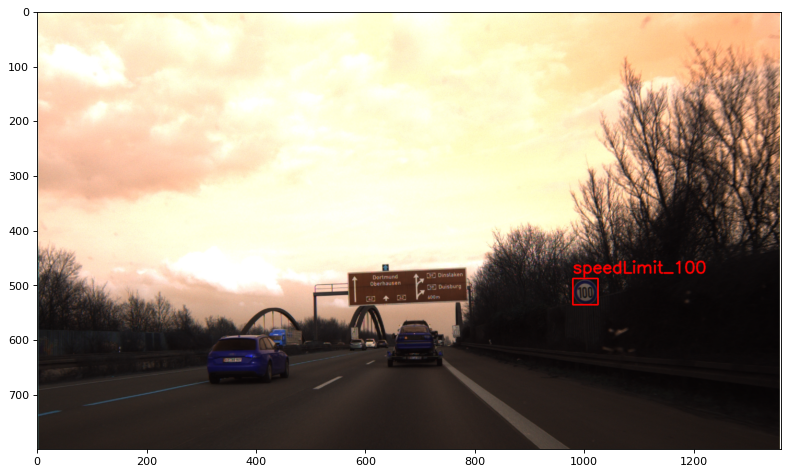

In [32]:
# we choose a random image and its corresponding annotation
random.seed()

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    h, w = image.shape[:2]
    
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
        
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        start_point=(int(x0),int(y0))
        end_point  =(int(x1),int(y1))
        # Blue color in BGR
        color = (255, 0, 0)

        # Line thickness of 2 px
        thickness = 2

        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        
        # font
        font = cv2.FONT_HERSHEY_SIMPLEX

        # Using cv2.putText() method
        image = cv2.putText(image, class_id_to_name_mapping[(int(obj_cls))], (int(x0), int(y0 - 10)), font, 
                           1, color, thickness, cv2.LINE_AA)
                     
    from matplotlib.pyplot import figure

    figure(figsize=(12, 10), dpi=80)
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = "dataset_YOLO/annotations/"+ random.choice(filenames)[:-3]+"txt"
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("dataset_YOLO/annotations/", "FullIJCNN2013/").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = cv2.imread(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [23]:
# Read images and annotations
images = [os.path.join('FullIJCNN2013', x) for x in os.listdir('FullIJCNN2013')if x[-3:] == "png" and x[:-3]+"ppm" in list(clean_df.filename)]
annotations = [os.path.join('dataset_YOLO/annotations', x) for x in os.listdir('dataset_YOLO/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [26]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'dataset_YOLO/images/train')
move_files_to_folder(val_images, 'dataset_YOLO/images/val/')
move_files_to_folder(test_images, 'dataset_YOLO/images/test/')
move_files_to_folder(train_annotations, 'dataset_YOLO/annotations/train/')
move_files_to_folder(val_annotations, 'dataset_YOLO/annotations/val/')
move_files_to_folder(test_annotations, 'dataset_YOLO/annotations/test/')